### **Nama : Maulana Agus Setiawan**
### **Dataset : https://www.kaggle.com/datasets/csafrit2/steel-industry-energy-consumption**

#### **Import Library**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

2024-01-14 17:16:21.912276: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 17:16:21.912340: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-14 17:16:21.912358: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-14 17:16:21.917155: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/scipy/__init__.py:1

#### **Read Dataset**

In [2]:
df = pd.read_csv('Steel_industry_data.csv')
df.tail()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
35035,31/12/2018 23:00,3.85,4.86,0.00,0.0,62.10,100.00,82800,Weekday,Monday,Light_Load
35036,31/12/2018 23:15,3.74,3.74,0.00,0.0,70.71,100.00,83700,Weekday,Monday,Light_Load
35037,31/12/2018 23:30,3.78,3.17,0.07,0.0,76.62,99.98,84600,Weekday,Monday,Light_Load
35038,31/12/2018 23:45,3.78,3.06,0.11,0.0,77.72,99.96,85500,Weekday,Monday,Light_Load
35039,31/12/2018 00:00,3.67,3.02,0.07,0.0,77.22,99.98,0,Weekday,Monday,Light_Load


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

#### **Mengecek Nilai Null**

In [4]:
df.isna().sum()

date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
dtype: int64

#### **Normalisasi Data**

In [5]:
mm = MinMaxScaler()
df['Usage_kWh'] = mm.fit_transform(df[['Usage_kWh']])

#### **Splitting Data**

In [6]:
date = df['date'].values
kwh = df['Usage_kWh'].values

X_train, X_test = train_test_split(kwh, test_size=0.2, shuffle=False)

In [7]:
print(X_train.shape)
print(X_test.shape)

(28032,)
(7008,)


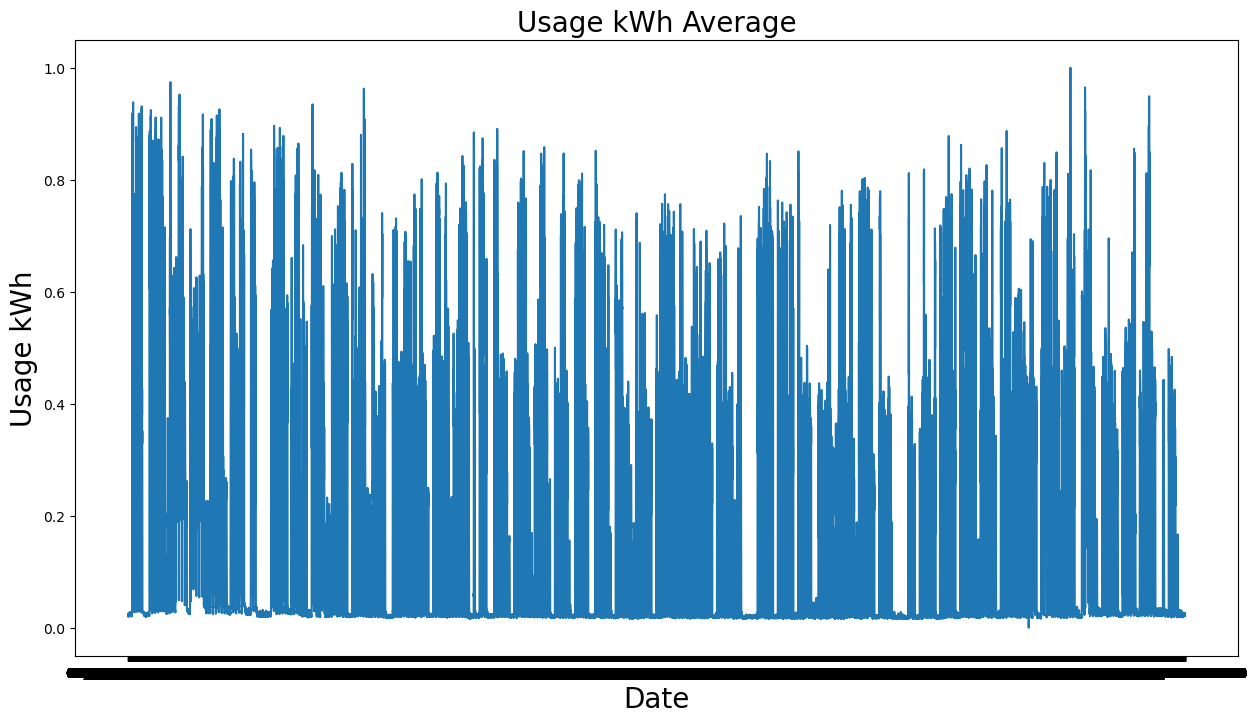

In [8]:
plt.figure(figsize=(15,8))
plt.plot(date, kwh)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Usage kWh', fontsize=20)
plt.title('Usage kWh Average', fontsize=20);

#### **Modelling Sequential**

In [9]:
# Merubah Data untuk dapat diterima model
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
# Modelling data
train_set = windowed_dataset(
    X_train,
    window_size=60,
    batch_size=100,
    shuffle_buffer=1000
)

val_set = windowed_dataset(
    X_test,
    window_size=60,
    batch_size=100,
    shuffle_buffer=1000
)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1),
])

2024-01-14 17:18:56.744921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-14 17:18:56.748545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-14 17:18:56.748581: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-14 17:18:56.750299: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-14 17:18:56.750333: I tensorflow/compile

In [11]:
threshold_mae = (df['Usage_kWh'].max() - df['Usage_kWh'].min()) * 10/100
print(threshold_mae)

0.1


In [12]:
class MyCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if(logs.get('val_mae') < threshold_mae and logs.get('mae') < threshold_mae):
        print(f"\nMAE telah berada dibawah : {threshold_mae}")
        self.model.stop_training = True

callbacks = MyCallBack()

In [13]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1.0000e-04
)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"]
)

history = model.fit(
    train_set,
    epochs=100,
    validation_data = val_set,
    callbacks = [callbacks]
)

Epoch 1/100


2024-01-14 17:18:57.368703: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-14 17:18:59.556397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-01-14 17:19:00.211154: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff74c004420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-14 17:19:00.211209: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-01-14 17:19:00.215405: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-14 17:19:00.283468: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    279/Unknown - 8s 15ms/step - loss: 0.0170 - mae: 0.1247

2024-01-14 17:19:05.091482: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2112040097093020175


280/280 [==============================] - 9s 20ms/step - loss: 0.0170 - mae: 0.1247 - val_loss: 0.0090 - val_mae: 0.0889
Epoch 2/100
  1/280 [..............................] - ETA: 35s - loss: 0.0168 - mae: 0.1250

2024-01-14 17:19:06.361398: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2112040097093020175
2024-01-14 17:19:06.361530: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14494040592168304708


277/280 [============================>.] - ETA: 0s - loss: 0.0090 - mae: 0.0848
MAE telah berada dibawah : 0.1
280/280 [==============================] - 5s 18ms/step - loss: 0.0089 - mae: 0.0846 - val_loss: 0.0066 - val_mae: 0.0681


In [14]:
predictions = model.predict(X_test[-60:][np.newaxis])
print(predictions)

1/1 [==============================] - 1s 946ms/step
[[0.05566705]]


In [15]:
print("Mean Absolute Error (MAE):", predictions)
print("Threshold MAE:", threshold_mae)

if predictions <= threshold_mae:
    print("-> BAIK")
else:
    print("-> TIDAK BAIK")

Mean Absolute Error (MAE): [[0.05566705]]
Threshold MAE: 0.1
-> BAIK
